In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob

from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from time import sleep

import sys

np.random.seed(10)

CURRPATH = os.getcwd()
DATAPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\data'
CODESPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\codes'
FILESPATH = DATAPATH + '\\files_lemm'

if CODESPATH not in sys.path:
    sys.path.append(CODESPATH)

from visualization import draw_wordcloud, draw_cluster_clouds

In [2]:
def read_to_df(folder: str, threshold=350):
    df = pd.DataFrame(columns=['univ', 'prog', 'name', 'text'])
    for file in glob.glob('{}/*/*/*.txt'.format(folder)):
        splitted = file.split('\\')
        name = splitted[-1][:-4]
        u = splitted[-3]
        op = splitted[-2]
        
        try:
            text = open(file, 'r').read()
        except Exception as e:
            print(e)
            print(file)
            text = open(file, 'r', encoding='utf-8').read()
        if len(text) < threshold:
            continue
        
        df = df.append({'univ':u, 'prog':op, 'name':name, 'text':text.lower()}, ignore_index=True)
    return df

In [3]:
df = read_to_df(FILESPATH)
len(df)

2380

In [4]:
df['cluster'] = ''
df_copy = df.copy()

# Разметка основной выборки (CS)
Будем использовать тот же алгоритм: кластеризация + ручная разметка. Используем TF-IDF и K-Means. Возьмем небольшое число кластеров для обобщения. Также будем править разметку расширения.

In [5]:
%load_ext autoreload

In [25]:
%autoreload 2
import gensim
from gensim.models import Word2Vec
from hyperparameters import w2v_kwargs

corpus = df.text.tolist()
corpus_splitted = [text.split() for text in corpus]
w2v_kwargs['window'] = 2000
w2v_kwargs['window'] = 20

w2v_vec_skip = Word2Vec(**w2v_kwargs, sg=1, hs=0)
w2v_vec_skip.build_vocab(corpus_splitted)
w2v_vec_skip.train(corpus_splitted, total_examples=w2v_vec_skip.corpus_count, epochs=w2v_vec_skip.epochs)

(4992384, 5118180)

In [27]:
%autoreload 2
from utils import idf_mean_vectorizer

w2v_skip_dict = dict(zip(w2v_vec_skip.wv.index_to_key, w2v_vec_skip.wv.vectors))
X_skip_idf = idf_mean_vectorizer(w2v_skip_dict).fit_transform(corpus)
X_skip_idf.shape

(2380, 1500)

In [28]:
N_CLUSTERS = 12

In [29]:
%autoreload 2
from hyperparameters import kmeans_kwargs_small
from sklearn.cluster import KMeans

kmeans_kwargs_small['n_clusters'] = N_CLUSTERS

km = KMeans(**kmeans_kwargs_small).fit(X_skip_idf)
km_labels = km.labels_

cluster: 1; samples: 106


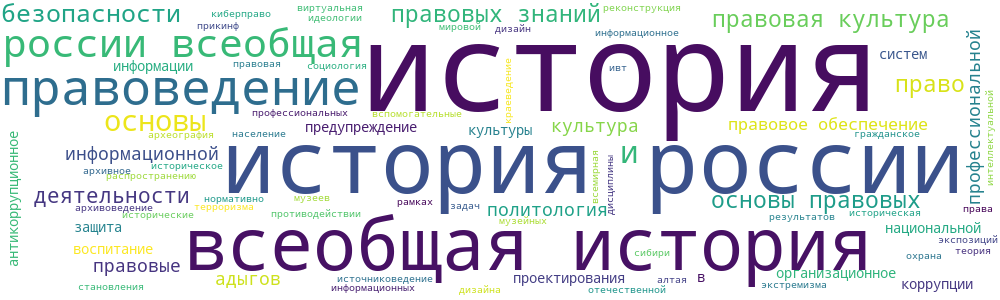

cluster: 2; samples: 131


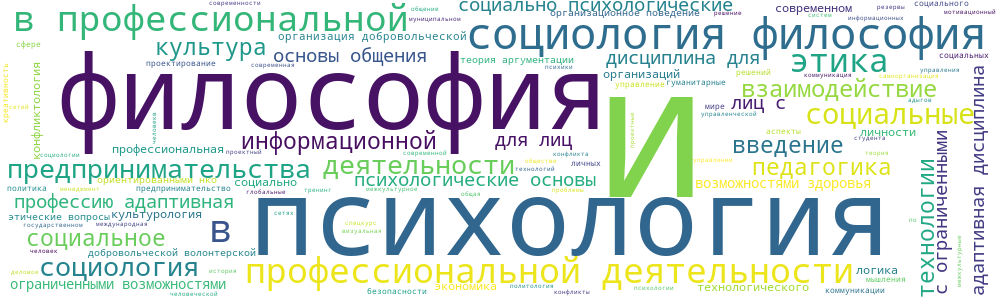

cluster: 3; samples: 76


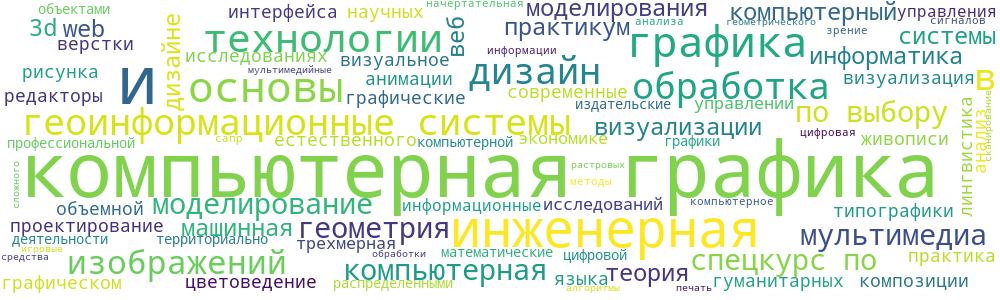

cluster: 4; samples: 368


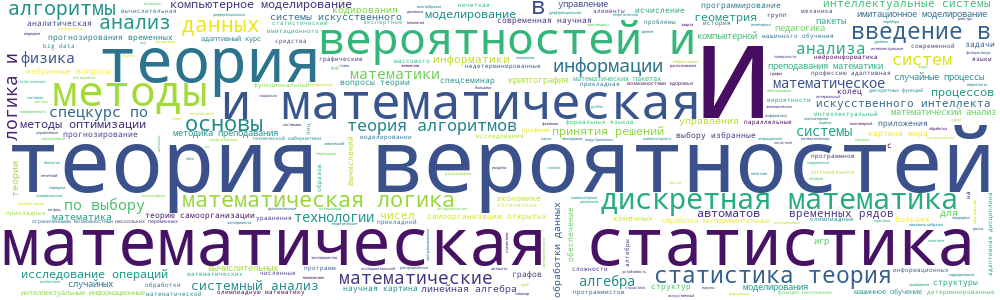

cluster: 5; samples: 405


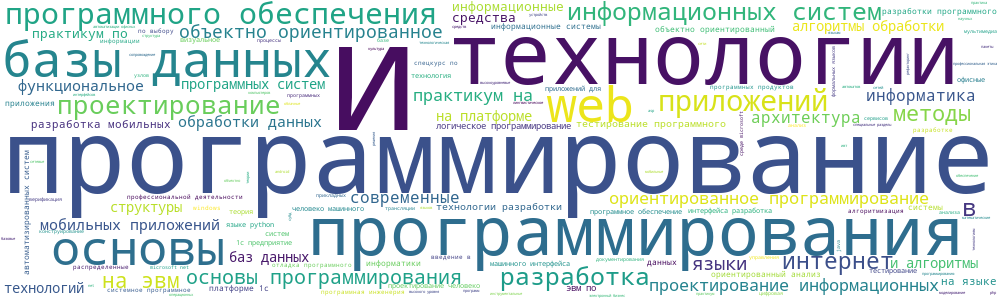

cluster: 6; samples: 536


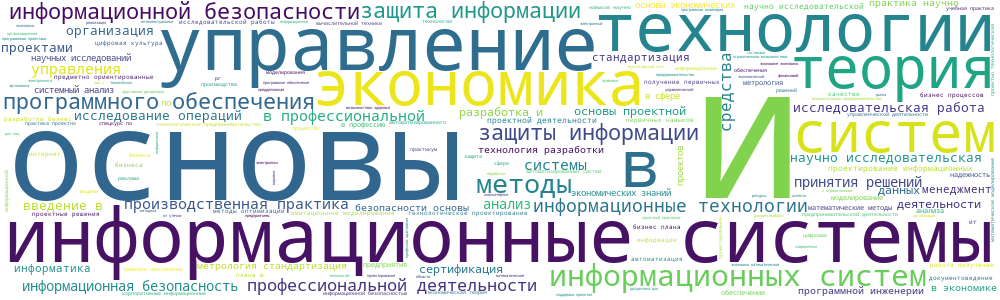

cluster: 7; samples: 123


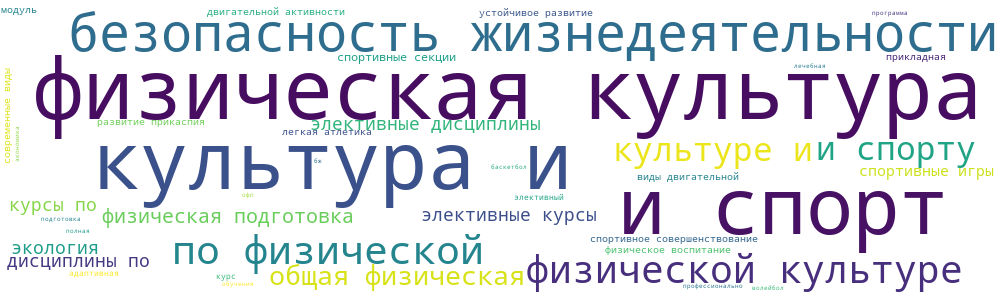

cluster: 8; samples: 256


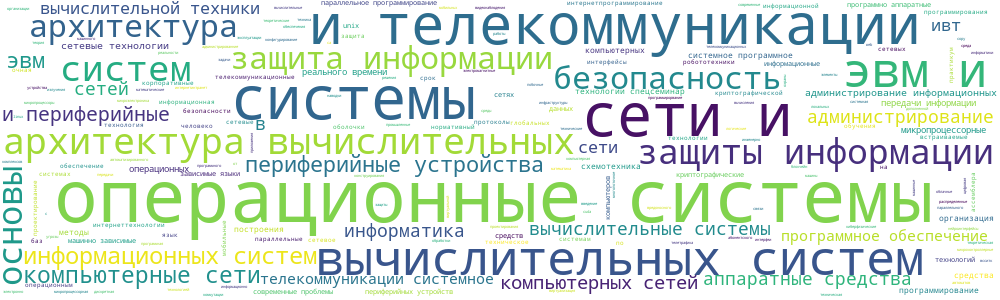

cluster: 9; samples: 217


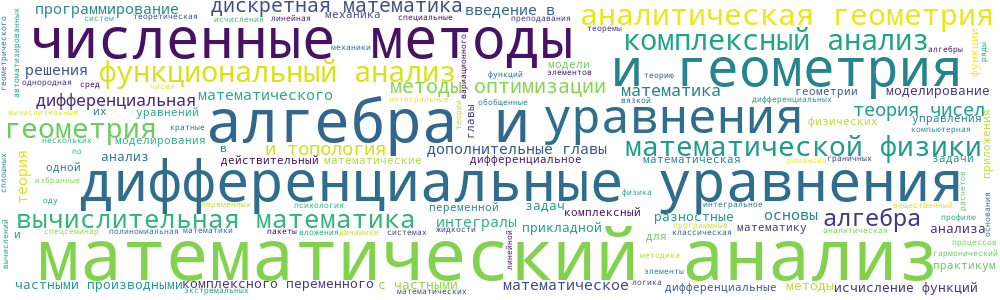

cluster: 10; samples: 19


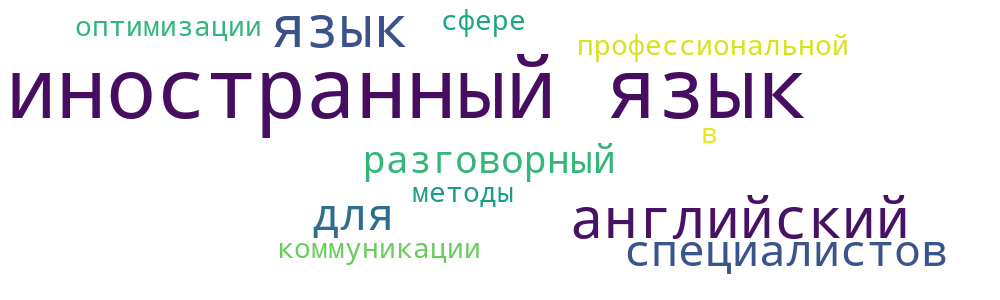

cluster: 11; samples: 62


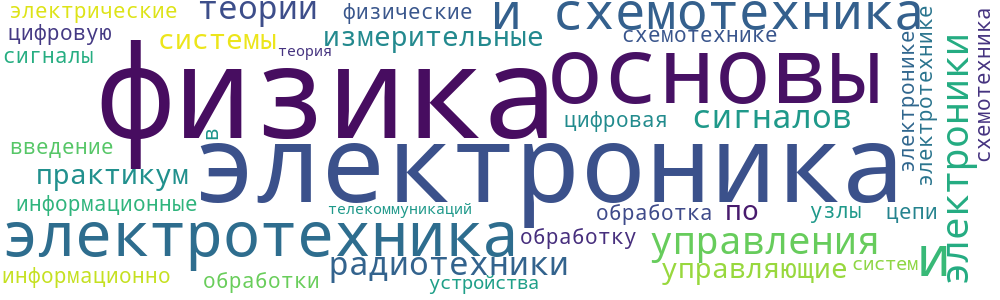

cluster: 12; samples: 81


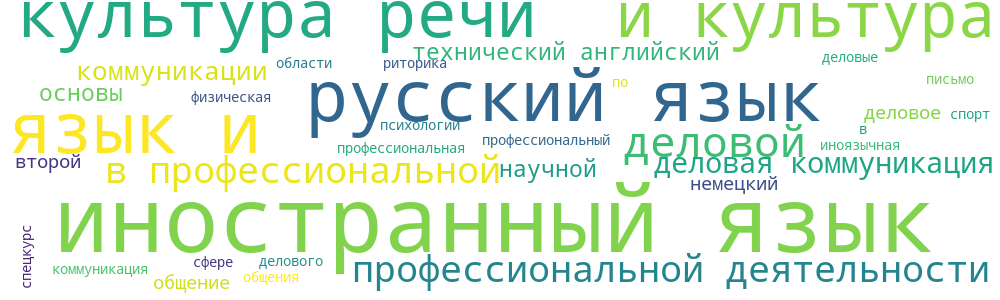

In [30]:
cloud_kwargs = { 'max_words':2000, 'width':1000, 'height':300 }
draw_cluster_clouds(df, km_labels, N_CLUSTERS, alert_by='name', cloud_kwargs=cloud_kwargs)

In [49]:
from metrics import get_inds

clusters_name = {
    1:'история и политика',
    2:'психология, социология и приложения',
    3:'компьютерная графика и дизайн',
    4:'информатика и математика', # условно - теоретическая информатика
    5:'программирование и разработка', # условно - практическая информатика
    6:'прочее',
    7:'спорт',
    8:'сети и системы',
    9:'математика',
    10:'иняз',
    11:'физика и химия',
    12:'языки',
}

In [50]:
for i in range(1, len(clusters_name) + 1):
    df_copy.loc[get_inds(km_labels, i - 1), 'cluster'] = clusters_name[i]

In [51]:
%autoreload 2
from utils import reclusterize

In [52]:
df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x, by='полит', new_cluster='история и политика')), axis=1)

In [58]:
df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x, by=
                                                                 ['защита информации', 'информационная безопасность',
                                                                  'компьютерная безопасность'],
                                                                 new_cluster='ИБ/КБ')), axis=1)

In [59]:
df_copy.cluster = df_copy.apply(lambda x: pd.Series(reclusterize(x, by=
                                                                 ['1c', 'бизнес', 'менеджмент', 'маркетинг'],
                                                                 new_cluster='бизнес, менеджмент и маркетинг')), axis=1)

In [53]:
inds = df_copy.loc[df_copy.name == 'безопасность жизнедеятельности'].index
df_copy.loc[inds, 'cluster'] = 'бжд'

## Ручная разметка

In [44]:
%autoreload 2
from utils import markup

In [46]:
markup(df_copy, km_labels, 1, folder='markup-2')

105 from 105
ПРАВО 
	 история и политика
право


* ИБ/КБ
* право

In [47]:
markup(df_copy, km_labels, 2, folder='markup-2')

130 from 130
ФИЛОСОФИЯ 
	 психология, социология и приложения



* бизнес, менеджмент и маркетинг
* экономика и финансы

In [54]:
markup(df_copy, km_labels, 3, folder='markup-2')

75 from 75
КОМПЬЮТЕРНАЯ ГРАФИКА 
	 компьютерная графика и дизайн



In [57]:
markup(df_copy, km_labels, 4, folder='markup-2')

367 from 367
ТЕОРИЯ ВЕРОЯТНОСТЕЙ И МАТЕМАТИЧЕСКАЯ СТАТИСТИКА 
	 математика



In [60]:
markup(df_copy, km_labels, 5, folder='markup-2')

404 from 404
ФУНКЦИОНАЛЬНОЕ И ЛОГИЧЕСКОЕ ПРОГРАММИРОВАНИЕ 
	 программирование и разработка



In [71]:
markup(df_copy, km_labels, 6, folder='markup-2')

535 from 535
ЭКОНОМИКА 
	 прочее
экономика и финансы


* программирование и разработка
* сети и системы (устройства, архитектура)
* ИБ/КБ
* экономика и финансы
* право
* бизнес, менеджмент и маркетинг
* психология, социология и приложения

In [61]:
markup(df_copy, km_labels, 7, folder='markup-2')

122 from 122
ЭКОЛОГИЯ 
	 спорт
химия, биология, экология и география


In [70]:
markup(df_copy, km_labels, 8, folder='markup-2')

255 from 255
ТЕХНОЛОГИИ ПАРАЛЛЕЛЬНОГО ПРОГРАММИРОВАНИЯ 
	 информатика
программирование и разработка


* программирование и разработка
* сети и системы (устройства, архитектура)
* ИБ/КБ

In [73]:
# markup(df_copy, km_labels, 9, folder='markup-2')

In [62]:
markup(df_copy, km_labels, 10, folder='markup-2')

18 from 18
ИНОСТРАННЫЙ ЯЗЫК 
	 иняз



In [63]:
markup(df_copy, km_labels, 11, folder='markup-2')

61 from 61
ФИЗИКА 
	 физика и химия



In [65]:
markup(df_copy, km_labels, 12, folder='markup-2')

80 from 80
ТЕХНИЧЕСКИЙ АНГЛИЙСКИЙ В ПРОФЕССИОНАЛЬНОЙ ОБЛАСТИ 
	 языки



In [75]:
for filename in glob.glob(CURRPATH + '\\markup-2\\*.txt'):
    cind = int(filename.split('\\')[-1][:-4])
    
    file = open(filename, 'r', encoding='ansi')
    splitted = file.read().split('; ')[:-1]
    file.close()
    
    inds = get_inds(km_labels, cind - 1)    
    df_copy.loc[inds, 'cluster'] = splitted

In [76]:
df_copy.cluster.unique()

array(['программирование и разработка', 'математика', 'информатика',
       'бжд', 'языки', 'ИБ/КБ', 'компьютерная графика и дизайн',
       'история и политика', 'сети и системы',
       'психология, социология и приложения', 'экономика и финансы',
       'право', 'спорт', 'физика и химия',
       'химия, биология, экология и география', 'прочее',
       'бизнес, менеджмент и маркетинг', 'иняз'], dtype=object)

In [77]:
inds = df_copy.loc[df_copy.name == 'иняз'].index
df_copy.loc[inds, 'cluster'] = 'языки'

In [78]:
other = df_copy[df_copy.cluster == 'прочее']
other_inds = other.index
other

,univ,prog,name,text,cluster
92,АГТУ,ИИТиК_информационная безопасность,основы управленческой деятельности,управленческий обучать определять круг рамка п...,прочее
123,АГТУ,ИИТиК_прикладная информатика,введение в специальность,введение специальность способ компьютерный спо...,прочее
138,АГТУ,ИИТиК_прикладная информатика,информационные системы электронного правительства,электронный правительство информационный-комму...,прочее
146,АГТУ,ИИТиК_прикладная информатика,мировые информационные ресурсы,мировой ресурс нормативный-правовой база регул...,прочее
170,АГТУ,ИИТиК_прикладная информатика,теория систем и системный анализ,системный стандарт оформление технический доку...,прочее
...,...,...,...,...,...
2216,ИМСИТ,ИИТиИ_автоматизированные системы обработки инф...,надежность эргономика и качество кс,надежность эргономика качество кс надежность э...,прочее
2242,ИМСИТ,ИИТиИ_автоматизированные системы обработки инф...,теория систем и са,са системный являться углубление уровень обуча...,прочее
2307,ИМСИТ,ИИТиИ_разработка и проектирование информационн...,теория систем и системный анализ,системный являться теоретический ознакомлять т...,прочее
2311,ИМСИТ,ИИТиИ_разработка и проектирование информационн...,управление информационными системами,преподавание являться получение стадия жизненн...,прочее


In [95]:
other.name.unique()

array(['основы управленческой деятельности', 'введение в специальность',
       'информационные системы электронного правительства',
       'мировые информационные ресурсы',
       'теория систем и системный анализ',
       'автоматизация управленческой деятельности',
       'инструментальные средства моделирования управленческих систем',
       'культурология', 'системы поддержки принятия решений',
       'теоретические основы автоматизированного управления',
       'документоведение', 'общая теория систем',
       'теория полезности и принятия решений',
       'спецкурс по выбору 2 введение в теорию самоорганизации открытых систем',
       'спецкурс по культурологии', 'спецкурс по культурологи 1',
       'основы научных исследований',
       'программное обеспечение систем автоматизированного проектирования',
       'системы электронного документооборота',
       'современная научная картина мира',
       'информационные системы в банковском деле',
       'информационные системы в ор

In [96]:
to_del = ['введение в специальность', 'основы научных исследований',
       'современная научная картина мира',
       'введение в профессию (адаптивная дисциплина для лиц с ограниченными возможностями здоровья)',
       'основы научно-исследовательской работы', 'спецсеминар',
       'метрология, стандартизация и сертификация',
       'форсайт-сессия «трансформация рынка труда и профессии будущего»',
       'введение в профессию',
       'методы научных исследований в профессиональной деятельности',
       'метрология стандартизация и сертификация в профессиональной деятельности',
       'научно-исследовательский практикум',
       'организация проведения научно-исследовательских и опытно-конструкторских работ',
       'основы проектной деятельности',
       'методика проведения научно-исследовательских работ',
       'выполнение и защита выпускной квалификационной работы',
       'научноисследовательская работа (получение первичных навыков научноисследовательской работы)',
       'производственная практика технологическая (проектнотехнологическая) практика',
       'технологическая (проектнотехнологическая) практика',
       'основы проектной и научно исследовательской деятельности',
       'учебная практика (технологическая (проектно технологическая) по основам информатики',
       'введение в направление', 'государственная итоговая аттестация',
       'производственная практика научно-исследовательская работа',
       'производственная практика преддипломная практика',
       'производственная практика проектно-технологическая практика',
       'учебная практика научно-исследовательская работа (получение первичных навыков научно-исследовательской работы)',
       'научно-исследовательский семинар',
       'методология научных исследований',
       'научно исследовательская работа',
       'основы научно производственной деятельности',]

inds = []
for subj in to_del:
    _ = df_copy[df_copy.name == subj.lower()].index.tolist()
    inds += _

In [99]:
df_copy.iloc[inds]

,univ,prog,name,text,cluster
123,АГТУ,ИИТиК_прикладная информатика,введение в специальность,введение специальность способ компьютерный спо...,прочее
1024,АлтГУ,ИЦТЭФ_безопасность автоматизированных систем (...,введение в специальность,введение специальность заключаться ознакомлени...,информатика
464,АлтГТУ,ФИТ_информатика и вычислительная техника,основы научных исследований,научный исследование ока-7 самоорганизация сам...,прочее
519,АлтГТУ,ФИТ_информационная безопасность,основы научных исследований,научный исследование ока-8 самоорганизация сам...,прочее
954,АлтГУ,ИМиИТ_математическое моделирование и информаци...,основы научных исследований,научный исследование необходимый теоретический...,прочее
...,...,...,...,...,...
2126,ВУиТ,ФИиТ_информатика и вычислительная техника,методология научных исследований,методология научный исследование сформировыват...,прочее
2131,ВУиТ,ФИиТ_информатика и вычислительная техника,научно исследовательская работа,научно исследовательский совершенствование нау...,прочее
2175,ВУиТ,ФИиТ_информационные системы и технологии,научно исследовательская работа,научно исследовательский совершенствование нау...,прочее
2134,ВУиТ,ФИиТ_информатика и вычислительная техника,основы научно производственной деятельности,научно производственный совершенствование науч...,прочее


In [103]:
df_copy.drop(index=inds, inplace=True)

## Конкатенация

In [111]:
df_new = pd.read_csv('data.csv', index_col=[0])
df_new

,univ,prog,name,text,cluster
0,АлтГТУ,производственный менеджмент,антикризисное управление,специфический инвестирование финансирование во...,"бизнес, менеджмент и маркетинг"
1,АлтГТУ,производственный менеджмент,безопасность жизнедеятельности,оказание чрезвычайный жизнедеятельность бжд пе...,бжд
2,АлтГТУ,производственный менеджмент,бизнес-планирование,моделировать бизнес-процесс реорганизация бизн...,"бизнес, менеджмент и маркетинг"
3,АлтГТУ,производственный менеджмент,бренд-менеджмент,операционный воздействие макроэкономический му...,"бизнес, менеджмент и маркетинг"
4,АлтГТУ,производственный менеджмент,бухгалтерский учет,отчетность последствие корпоративный учетный о...,"бизнес, менеджмент и маркетинг"
...,...,...,...,...,...
2063,ИМСИТ,экономика финансы и учёт 3++,финансы,финансы будущий профессия конечный функциониро...,экономика и финансы
2064,ИМСИТ,экономика финансы и учёт 3++,эконометрика,эконометрика эконометрический количественный к...,математика
2065,ИМСИТ,экономика финансы и учёт 3++,экономика предприятия организации,нацеливать хозяйствовать организационно-правов...,экономика и финансы
2066,ИМСИТ,экономика финансы и учёт 3++,экономическая информатика,информатика вычислительный машина вычислительн...,информатика


In [113]:
df = pd.concat([df_copy, df_new], ignore_index=True)
df

,univ,prog,name,text,cluster
0,АГТУ,ИИТиК_информатика и вычислительная техника,администрирование операционных систем,администрирование операционный разрабатывать б...,программирование и разработка
1,АГТУ,ИИТиК_информатика и вычислительная техника,алгебра и геометрия,алгебра геометрия естественнонаучный общеинжен...,математика
2,АГТУ,ИИТиК_информатика и вычислительная техника,алгоритмы и структуры данных,разрабатывать программа пригодный алгоритмичес...,информатика
3,АГТУ,ИИТиК_информатика и вычислительная техника,"архитектура вычислительных систем, операционны...",архитектура вычислительный операционный число ...,программирование и разработка
4,АГТУ,ИИТиК_информатика и вычислительная техника,безопасность жизнедеятельности,жизнедеятельность создавать поддерживать повсе...,бжд
...,...,...,...,...,...
4373,ИМСИТ,экономика финансы и учёт 3++,финансы,финансы будущий профессия конечный функциониро...,экономика и финансы
4374,ИМСИТ,экономика финансы и учёт 3++,эконометрика,эконометрика эконометрический количественный к...,математика
4375,ИМСИТ,экономика финансы и учёт 3++,экономика предприятия организации,нацеливать хозяйствовать организационно-правов...,экономика и финансы
4376,ИМСИТ,экономика финансы и учёт 3++,экономическая информатика,информатика вычислительный машина вычислительн...,информатика


In [114]:
other = df_copy[df_copy.cluster == 'прочее']
other_inds = other.index
other

,univ,prog,name,text,cluster
92,АГТУ,ИИТиК_информационная безопасность,основы управленческой деятельности,управленческий обучать определять круг рамка п...,прочее
138,АГТУ,ИИТиК_прикладная информатика,информационные системы электронного правительства,электронный правительство информационный-комму...,прочее
146,АГТУ,ИИТиК_прикладная информатика,мировые информационные ресурсы,мировой ресурс нормативный-правовой база регул...,прочее
170,АГТУ,ИИТиК_прикладная информатика,теория систем и системный анализ,системный стандарт оформление технический доку...,прочее
210,АГУ,ИФФ_автоматизированные системы обработки инфор...,автоматизация управленческой деятельности,автоматизация управленческий самоорганизация с...,прочее
...,...,...,...,...,...
2216,ИМСИТ,ИИТиИ_автоматизированные системы обработки инф...,надежность эргономика и качество кс,надежность эргономика качество кс надежность э...,прочее
2242,ИМСИТ,ИИТиИ_автоматизированные системы обработки инф...,теория систем и са,са системный являться углубление уровень обуча...,прочее
2307,ИМСИТ,ИИТиИ_разработка и проектирование информационн...,теория систем и системный анализ,системный являться теоретический ознакомлять т...,прочее
2311,ИМСИТ,ИИТиИ_разработка и проектирование информационн...,управление информационными системами,преподавание являться получение стадия жизненн...,прочее


Наконец, сохраним данные с разметкой.

In [116]:
df.to_csv(DATAPATH + '.csv', index=False)